In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from joblib import parallel_backend
import shap
import pickle

# Custom modules
from ozzy_torch_utils.subject_dataset import *

np.set_printoptions(precision=2, suppress=True)

In [4]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the disease labels
labels_string = 'research_group'

In [5]:
dataset = SubjectDataset(data_path, selected_labels, data_string='volumes')

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort/idaSearch_3_19_2025.csv']


In [6]:
labels = np.array([dataset[index]['research_group'] for index in range(len(dataset.subject_list))])

volumes = np.array([dataset[index]['volumes'] for index in range(len(dataset.subject_list))])

print(f"Unique labels: {np.unique(labels, return_counts=True)}\n")

Unique labels: (array([0, 1]), array([195, 348]))



In [7]:
scoring = 'accuracy'
n_estimators=4
learning_rate=0.1 
max_depth=3

with parallel_backend('threading', n_jobs=8):

    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)

    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, volumes, labels, cv=cv, scoring=scoring)

    print(f'Cross-validation {scoring} scores: {cv_scores}')
    print(f'Mean cross-validation {scoring}: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation {scoring}: {np.std(cv_scores)}')

Cross-validation accuracy scores: [0.65 0.67 0.64 0.67 0.61 0.65 0.65 0.65 0.65 0.67]
Mean cross-validation accuracy: 0.65006734006734
Standard deviation of cross-validation accuracy: 0.016747279793189695


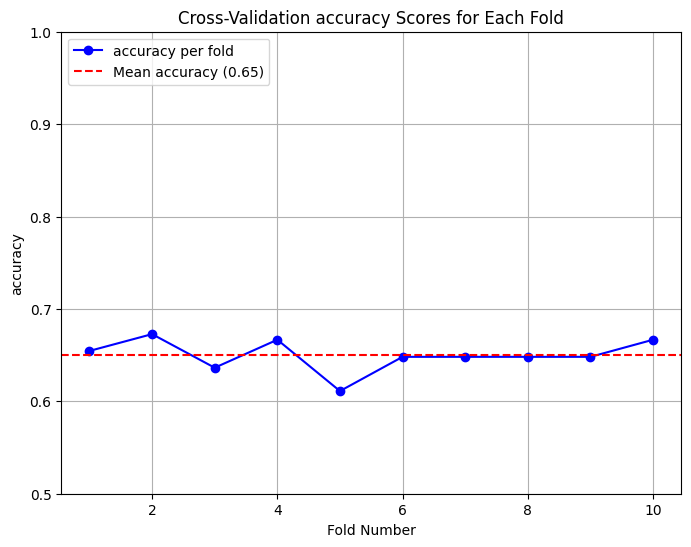

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label=f'{scoring} per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean {scoring} ({np.mean(cv_scores):.2f})')
plt.title(f'Cross-Validation {scoring} Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel(f'{scoring}')
plt.ylim(0.5,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

0.5624262969561182


<Axes: >

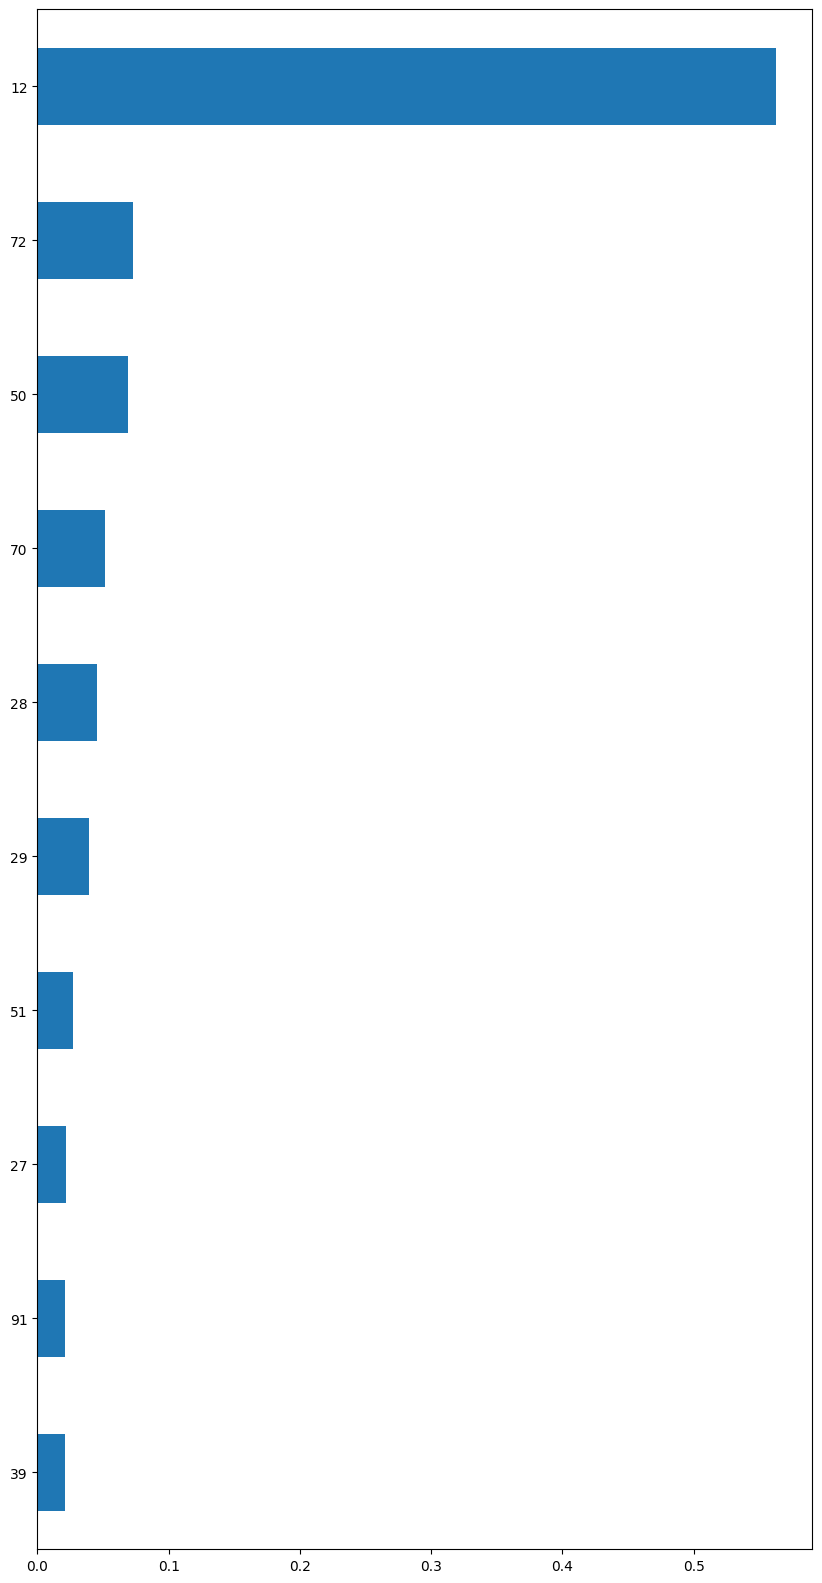

In [9]:

model.fit(volumes, labels)
feature_importance = pd.Series(model.feature_importances_)
print(max(feature_importance))
feature_importance.sort_values()[-10:].plot(kind="barh", figsize = (10, 20))

543


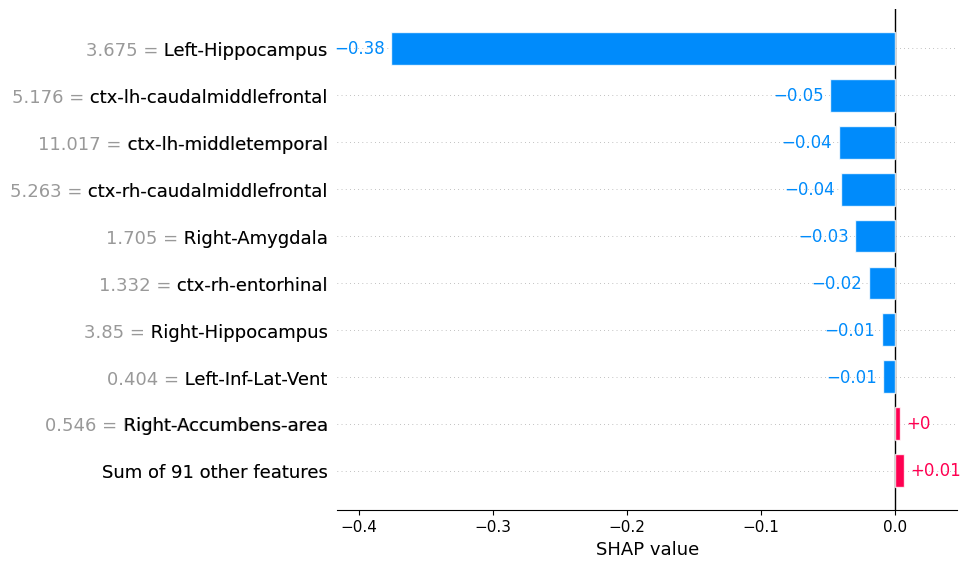

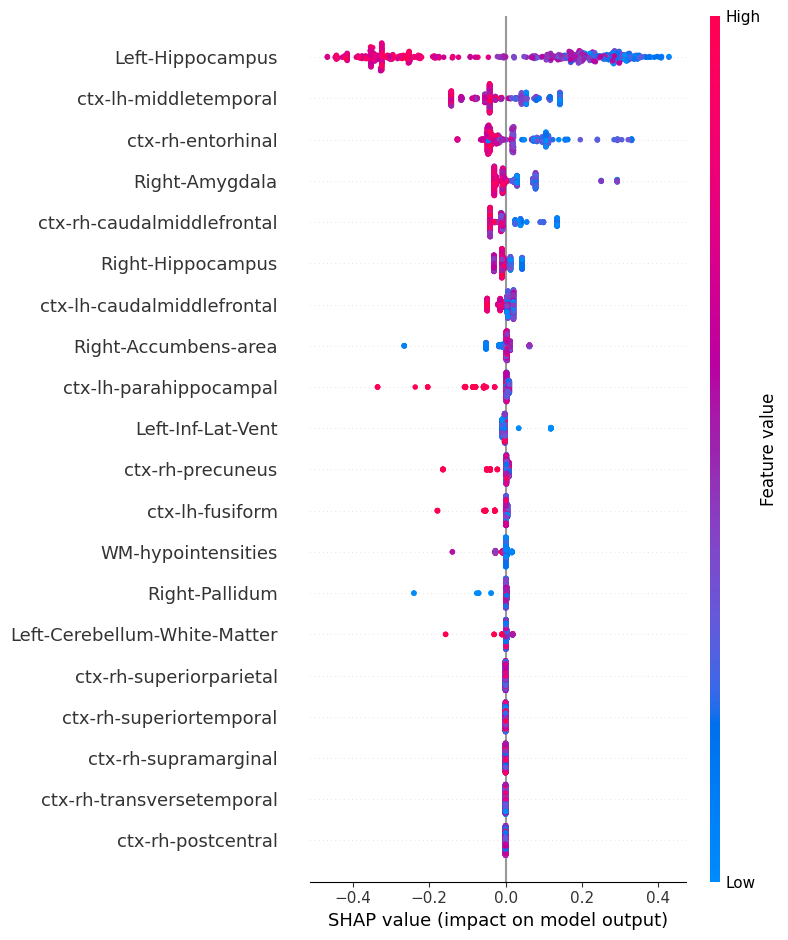

In [10]:
model = GradientBoostingClassifier(n_estimators=4, learning_rate=0.1, max_depth=3)

model.fit(volumes, labels)

explainer = shap.Explainer(model, feature_names=dataset[0]['struct_names'])

shap_values = explainer(volumes)

print(len(shap_values))

shap.plots.bar(shap_values[0], max_display=10)

shap.summary_plot(shap_values, volumes)


In [11]:
with open(f'volumes_gbdt.pkl', 'wb') as file:
    
    pickle.dump(model, file)  
